[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ecotrust/fbstac_plots/blob/main/notebooks/crawling_forestplots_catalog.ipynb)

# Exploring ForestStructure STAC catalog

This notebook illustrates how to load ForestStructure, explore the catalog metadata, select and fetch data into a local directory, and create a new local catalog pointing to downloaded data.

Contents:
- [Import required packages](#Import-required-packages)
- [Load catalog](#Load-catalog)
- [Load a forest plot collection and explore the metadata](#load-forest-plot-collection)
- [Visualize forest plots and source data](#visualize-forest-plots)
- [Filter forest plots by data availability](#filter-forest-plots)
- [Download source data (assets)](#download-source-data)

Browse [Forest Plot STAC](https://radiantearth.github.io/stac-browser/#/external/fbstac-stands.s3.amazonaws.com/plots/catalog/catalog.json) using Radiant Earth [stac-browser](https://github.com/radiantearth/stac-browser).

## Install and import required libraries

In [1]:
!pip install pystac folium wget

In [2]:
import os
from pathlib import Path

import folium
import geopandas as gpd
import shapely.geometry as Geometry
from pystac import Item, Catalog, CatalogType

from IPython.display import display, Markdown, Image

## Load catalog

ForestStructure is organized into eleven plot collections, one collection per survey effort, and six dataset collections for NAIP, Landsat 8, Lidar, Lidar-derived rasters, Digital Elevation Model, and DEM - Derived Topographic Metrics.

In [3]:
root_catalog = Catalog.from_file('https://fbstac-stands.s3.amazonaws.com/plots/catalog/catalog.json')

In [4]:
# Print some basic metadata about the Catalog
print(f"ID: {root_catalog.id}")
print(f"Title: {root_catalog.title or 'N/A'}")
print(f"Description: {root_catalog.description or 'N/A'}")

ID: fbstac-plots
Title: Forest plots STAC for benchmarking and modeling.
Description: Oregon and Washington State forest plots, attributes, and imagery STAC for forest benchmarking and modeling.


In [5]:
collections = list(root_catalog.get_collections())

print(f"Number of collections: {len(collections)}")
print("Forest Plots collections IDs:")
plot_collection_ids = []
datasets_collection_ids = []
for fplots in collections:
    is_plot = fplots.id.endswith("plots")
    if is_plot:
        plot_collection_ids.append(fplots.id)
        print(f"- {fplots.id}")

print("Datasets collections IDs:")
for fplots in collections:
    is_plot = fplots.id.endswith("plots")
    if not is_plot:
        datasets_collection_ids.append(fplots.id)
        print(f"- {fplots.id}")

Number of collections: 17
Forest Plots collections IDs:
- blm-coos-plots
- blm-lane-plots
- blm-rogue-plots
- wa-dnr-plots
- usfs-blue-mountains-plots
- usfs-fremont-winema-plots
- usfs-gifford-pinchot-plots
- usfs-mount-baker-snoqualmie-plots
- usfs-rogue-plots
- usfs-umpqua-plots
- usfs-wenatchee-plots
Datasets collections IDs:
- 3dep
- naip
- lidar-rast
- 3dep-dtm
- landsat8
- lidar


## Load a forest plot collection <a class="anchor" id="load-forest-plot-collection"></a>

In [7]:
fplots = root_catalog.get_child("usfs-blue-mountains-plots")
fplots

<Collection id=usfs-blue-mountains-plots>

The collection description is compatible with markdown syntax.

In [8]:
display(Markdown(f"## {fplots.id}\n\n{fplots.description}"))

## usfs-blue-mountains-plots

Forest plots from the US Forest Service Blue Mountains National Forest.


Additional resources:
- [Plot Survey Field Procedures](https://fbstac-stands.s3.amazonaws.com/plots/documents/USFS_2018_Region_6_LiDAR_Field_Plot_Procedures_V2.pdf)
- [Plot Survey Raw Database](https://fbstac-stands.s3.amazonaws.com/plots/raw/usfs/FVS_Data.sqlite)


Retrive forest plots items

In [9]:
items = list(fplots.get_items())
print(f"Number of items: {len(items)}")

Number of items: 2445


In [10]:
item = items[0]
item.id

'3ca58372_2021_usfs-blue-mountains-label'

In [11]:
item.datetime

datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzutc())

In [12]:
item.collection_id

'usfs-blue-mountains-plots'

In [13]:
item.stac_extensions

['https://stac-extensions.github.io/label/v1.0.1/schema.json']

In [14]:
item.bbox

[-121.13873118831786, 43.4732557147189, -121.13724828051431, 43.47433566415578]

In [15]:
item_g = gpd.GeoDataFrame.from_features(item.geometry['features'])
item_g.T

0
geometry                 POLYGON ((-121.13724828051431 43.4732557147189...
tpa                                                                     12
ba                                                                      23
sdi                                                                     33
ccf                                                                     17
qmd                                                              18.947544
tcuft                                                                  887
topht                                                                   56
number_of_strata                                                         1
total_cover                                                              7
structure_class                                                       5=OS
canopy_baseheight                                                       25
canopy_bulkdensity                                                0.006965
aboveground_biomass                                                     18
aboveground_carbon                                                       8
aboveground_live_carbon                                                  8
gs_tpa                                                                  12
lat                                                              43.473796
lon                                                             -121.13799
orig_id                                                    060105040480258
source                                                 USFS-BLUE-MOUNTAINS
meas_yr                                                               2015
ecoregion3                           eastern_cascades_slopes_and_foothills
agency                                                                USFS
plot_size_ac                                                          0.25
bulk_dens                                                               87
soil_depth                                                           152.0
pct_clay_surf                                                            4
pct_rock_surf                                                            9
pct_sand_surf                                                           77
distance_to_water_m                                            4807.839359
pot_veg_type                                                          1053
epsg                                                                 32610
utm_x                                                        650599.511325
utm_y                                                       4815115.160085
utm_xmin                                                     650539.511325
utm_ymin                                                    4815055.160085
utm_xmax                                                     650659.511325

In [16]:
sources = [link.absolute_href for link in item.links if link.rel == "source"]
sources

['/home/ygalvan/stac/fbstac-plots/3dep/3ca58372_USFS_3DEP_1mDEM/3ca58372_USFS_3DEP_1mDEM.json',
 '/home/ygalvan/stac/fbstac-plots/naip/3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ/3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ.json',
 '/home/ygalvan/stac/fbstac-plots/3dep-dtm/3ca58372_USFS_3DEP_10mDEM-DTM/3ca58372_USFS_3DEP_10mDEM-DTM.json',
 '/home/ygalvan/stac/fbstac-plots/landsat8/3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon/3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon.json']

In [17]:
linked_items = [Item.from_file(source) for source in sources]
linked_items

[<Item id=3ca58372_USFS_3DEP_1mDEM>,
 <Item id=3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ>,
 <Item id=3ca58372_USFS_3DEP_10mDEM-DTM>,
 <Item id=3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon>]

In [18]:
linked_item = linked_items[1]

In [19]:
#  Slow
# linked_items = [root_catalog.get_item(s, recursive=True) for s in sources]
# linked_item = root_catalog.get_item(sources[1], recursive=True)

In [20]:
# Expensive operation
# assets = linked_item.get_assets()

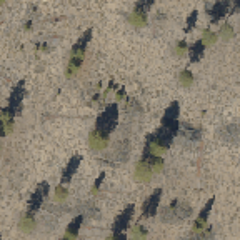

In [21]:
Image(linked_item.assets["thumbnail"].href)

## Visualize forest plots and source data <a class="anchor" id="visualize-forest-plots"></a> 

Map all forest plots

In [22]:
plot_features = [item.geometry['features'][0] for item in items]# if item.datetime.year == 2019]
uuids = [item.id.split('_')[0] for item in items]

gdf = gpd.GeoDataFrame.from_features(plot_features, 
        columns=['geometry']
)
gdf.insert(0, 'uuid', uuids)

gdf.drop_duplicates(subset=['geometry'], inplace=True)

In [23]:
plots_geom = Geometry.box(*gdf.total_bounds)
x, y = plots_geom.centroid.coords[0]

plot_map = folium.Map(
    location=(y, x), 
    zoom_start = 8
)

geo_j = folium.GeoJson(
    data=plots_geom.__geo_interface__, 
    # style_function=lambda x: {"fillColor": "orange"}
)

geo_j.add_to(plot_map);

In [24]:
for idx, row in gdf.iterrows():
    geo_j = folium.GeoJson(
        data=row.geometry.__geo_interface__, 
        style_function=lambda x: {"fillColor": "orange"}
    )

    geo_j.add_to(plot_map);

In [25]:
plot_map

Preview a single NAIP asset

In [26]:
geo_j = folium.GeoJson(
    data=item_g.geometry.__geo_interface__, 
)

x, y = item_g.geometry[0].centroid.coords[0]

thumb = folium.raster_layers.ImageOverlay(
    name='thumbnail',
    image=linked_item.assets["thumbnail"].href,
    bounds=[[item.bbox[1], item.bbox[0]], [item.bbox[3], item.bbox[2]]],
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

thumb.add_to(plot_map);

plot_map.fit_bounds(geo_j.get_bounds())

In [27]:
plot_map

## Filter forest plots by data availability <a class="anchor" id="filter-forest-plots"></a>

First, we will define a couple of functions to help us crawl the items' metadata within a collection in a fast and efficient way.

In [28]:
def has_datasets(item, collection_ids: list):
    """Check if the item has the datasets in the given collection_id list.

    Args:
        item (pystac.Item): Plot item to check.
        collection_ids (list): List like object with collection IDs to check for.
    """
    assert isinstance(collection_ids, list  or tuple), "collection_ids must be a list or tuple"
    
    # get the source absolute path to dataset items
    sources = [link.absolute_href for link in item.links if link.rel == "source"]
    # Load the dataset items from file. This is faster than using catalog.get_item()
    _items = [Item.from_file(source) for source in sources]
    
    return set(collection_ids).issubset([_item.collection_id for _item in _items])

def count_sources(item):
    """Count the number of sources for the given item.
    """
    # get the source absolute path to dataset items
    sources = [link.absolute_href for link in item.links if link.rel == "source"]
    return len(sources)

Check if the item has a lidar asset

In [29]:
has_datasets(item, ['lidar'])

False

Get all forest plots in the collection that contain data from all datasets: 3dep, 3dep-dtm, lidar, lidar-rast, naip, and landsat8

In [30]:
# Items with complete datasets
complete_items = [item for item in items if count_sources(item) == len(datasets_collection_ids)]

In [31]:
len(complete_items)

280

In [32]:
has_datasets(complete_items[0], ['lidar'])

True

Get all forest plots that have landsat8 data

In [33]:
# This may take a few minutes to complete if fetching from S3
items_ls8 = [item for item in items if has_datasets(item, ['landsat8'])]
len(items_ls8)

2445

## Download source data (assets) <a class="anchor" id="download-source-data"></a>

Define helper functions to download data

In [45]:
import concurrent.futures
from tqdm import tqdm
import wget

def get_item_assets(item):
    """
    """    
    # get the source absolute path to dataset items
    sources = [link.absolute_href for link in item.links if link.rel == "source"]
    # Load the dataset items from file. This is faster than crawling the catalog
    return [Item.from_file(source) for source in sources]

def download_assets(item, outpath):
    """Download all assets of the given item and update the hrefs.
    """
    new_item = item.clone()
    outpath = Path(outpath) 
    for k, v in item.assets.items():
        filename = '/'.join(Path(v.href).parts[4:])
        outfile = outpath / filename            
        outfile.parent.mkdir(parents=True, exist_ok=True)        
        wget.download(v.href, out=outfile.as_posix())
        # Update the href to the local file
        new_item.assets[k].href = os.path.abspath(outfile)
    
    return new_item

Create new local catalog for downloaded data

In [35]:
new_catalog = Catalog(
    id=root_catalog.id, 
    description=root_catalog.description,
    title=root_catalog.title
)

Create new forest plots collection with selected items

In [36]:
new_fplots = fplots.clone()
new_fplots.clear_items()
new_fplots.add_items(complete_items)
new_fplots.update_extent_from_items()
new_catalog.add_child(new_fplots)
new_fplots

<Collection id=usfs-blue-mountains-plots>

Collect all items assets to download

In [40]:
# This may take a few minutes to complete if fetching from S3
assets = [get_item_assets(item) for item in complete_items]

Download data using a thread pool. The function download_assets will download all assets in the list of assets provided and modify the item metadata to include the local path to the downloaded asset.

In [46]:
new_items = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(download_assets, item, '../data/stac/data') for sbl in assets for item in sbl]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        new_items.append(future.result())

  0%|          | 0/1680 [00:00<?, ?it/s]

100%|██████████| 1680/1680 [01:17<00:00, 21.66it/s]


Update dataset collections with updated items

In [38]:
for dts in datasets_collection_ids:
    new_dts = root_catalog.get_child(dts).clone()
    new_dts.clear_items()
    new_dts.add_items([item for item in new_items if item.collection_id == dts])
    new_dts.update_extent_from_items()
    new_catalog.add_child(new_dts)

Save the new catalog to disk

In [39]:
new_catalog.normalize_hrefs('../data/stac/catalog')
new_catalog.validate()
new_catalog.save(catalog_type=CatalogType.SELF_CONTAINED)

Verify the new local catalog and load an image preview to test the updated hrefs pointing to local files.

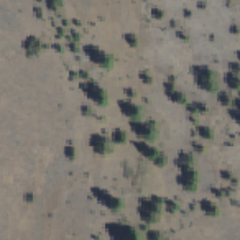

In [40]:
naip_coll = Catalog.from_file('../data/stac/catalog/catalog.json').get_child('naip')
item = list(naip_coll.get_items())[0]
Image(item.assets['thumbnail'].href)